
## Artificial Neural Network Model 

#### A neural network classifier

-  We perform GridSearch to find optimal parameters
- The model has the folowing layers:  
    -  A Vectorization layer to turn input text to numerical sequences
    -  An Embedding layer with embedding_dim dimension for each embedding 
    -  A one dimentional (1D) convolutional neural network
    -  A one dimentional global max pooling layer  
    -  A fully connected layer with 10 units 
    -  The output layer is one neuron with sigmoid activation producing the output label
    -  Dropout layers added to minimize overfitting on the small datasets
            

In [1]:
import matplotlib.pyplot as plt
from time import time
import re

# we use tensorflow to create our neural network for this experiment 
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

     |████████████████████████████████| 76 kB 3.3 MB/s 
  Created wheel for reload: filename=reload-0.9-py3-none-any.whl size=2881 sha256=68a7bb54f125d18b2f121507c42d7b13352fac26700abea3714c9436a007dcf3
  Stored in directory: /root/.cache/pip/wheels/f1/a2/ff/3f7b4879e081247a0e1381fd6699e86e0732ca0c365be41634
Successfully built reload


In [ ]:
!pip install tensorcross

In [ ]:
# import the preprocessing functions we've made 
import preprocess

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/Shared drives/PFE/Colab Notebooks
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<module 'preprocess' from '/content/gdrive/Shared drives/PFE/Colab Notebooks/preprocess.py'>

In [ ]:
# import the advertising dataset 
# Each ad has a binary label 0 for commercial and 1 for informational ads 
df = preprocess.get_data('./data/task1_dataset.csv', columns_to_drop= False )
df = df.iloc[: , 1:]
# removing links from the data 
df["text"] = df["text"].apply(lambda text: re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', text, flags=re.MULTILINE))

df.head()

,label,text
0,0,"""My Thistle subscription has changed my work f..."
1,0,"After I bought this toy for my child, he staye..."
2,0,A Black Friday purchase you actually won't reg...
3,0,"The Nutcracker, accompany you and your family ..."
4,0,ohora’s NEW COLLECTION - shop right away ⠀ It...


In [ ]:
# Cleaning the data 
clean_data = preprocess.preprocess_data(df['text'])

df['clean_data'] = clean_data
df['clean_data'] = df['clean_data'].apply(lambda x: re.sub(r'[0-9]+', '', x))
df['clean_data'] = df['clean_data'].apply(lambda x: re.sub(' +', ' ', x))

df.head()

,label,text,clean_data
0,0,"""My Thistle subscription has changed my work f...",thistle subscription changed work home life sa...
1,0,"After I bought this toy for my child, he staye...",bought toy child stayed away ipadtablet tv pro...
2,0,A Black Friday purchase you actually won't reg...,black friday purchase actually wont regret sto...
3,0,"The Nutcracker, accompany you and your family ...",nutcracker accompany family warm holiday
4,0,ohora’s NEW COLLECTION - shop right away ⠀ It...,ohora’s new collection shop right away ⠀ getti...


In [ ]:
# Splitting data into training and testing datasets
(train_data, test_data) = preprocess.eval_train_split(df['clean_data'], df['label'], validation= False, test_size = 0.1)

X_train = train_data[0]
y_train = train_data[1]
X_test = test_data[0]
y_test = test_data[1]
batch_size = 1024 
# prepping training and testing datasets 
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
test_data  = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)


In [ ]:
def create_model(units, vocab_size, embedding_dim, maxlen,vectorize_layer, dropout = 0.2):
  '''
    Create a convolutional neural network used for binary text classification task
    Arguments : 
      num_filters: number of filters to use for the 1D convolution layer 
      kernel_size: kernal size used for convolution
      embedding_dim: embedding size 
      maxlen: input sequence length
      vectorize_layer : vectorization layer for turning input text to numerical sequences
      dropout : dropout rate used for Dropout regularization layer to minimize overfitting

    Returns : 
    A model with the folowing layers:  
            - A Vectorization layer to turn input text to numerical sequences
            - An Embedding layer with embedding_dim dimension for each embedding 
            - A one dimentional (1D) convolutional neural network
            - A one dimentional global max pooling layer  
            - A fully connected layer with 10 units 
            - The output layer is one neuron with sigmoid activation producing the output label
            - Dropout layers added to minimize overfitting on the small datasets 
  '''
  model = Sequential([
      vectorize_layer,
      layers.Embedding(input_dim = vocab_size , output_dim = embedding_dim, input_length=maxlen),
      layers.Dropout( rate = dropout ),
      layers.GlobalMaxPooling1D(),
      layers.Dropout( rate = dropout),
      layers.Dense(units, activation='relu'),
      layers.Dropout( rate = dropout ),
      layers.Dense(1, activation='sigmoid')              
  ])
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

Model: "sequential_148"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_19 (Text  (None, 100)              0         
 Vectorization)                                                  
                                                                 
 embedding_148 (Embedding)   (None, 100, 50)           500000    
                                                                 
 dropout_444 (Dropout)       (None, 100, 50)           0         
                                                                 
 global_max_pooling1d_148 (G  (None, 50)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dropout_445 (Dropout)       (None, 50)                0         
                                                                 
 dense_296 (Dense)           (None, 10)             

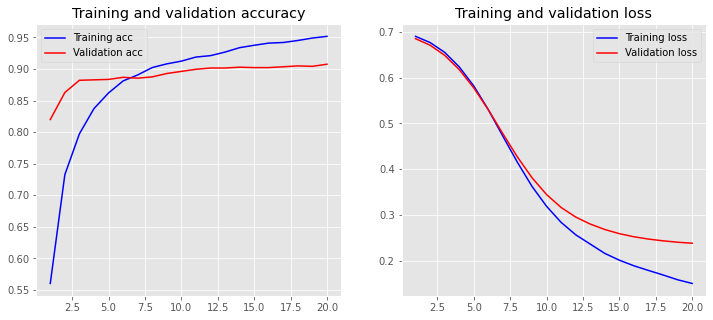

In [ ]:
# Making a vectorization layer to turn input text to numerical sequences
vectorize_layer = layers.TextVectorization( max_tokens = 10000, output_sequence_length = 100)

# Making a vocabulary with input text sequences
vectorize_layer.adapt( train_data.map(lambda x, y: x) )

# Creating a neural net with randomly set paramteres as a baseline comparison model 
model = create_model(10, 10000, 50, 100,vectorize_layer)
model.summary()

# Train the neural net and evaluate results 
history = model.fit(train_data, epochs = 20, batch_size = 10, verbose = 1, validation_data = test_data)
plot_history(history)

In [ ]:
from tensorcross.model_selection import GridSearchCV
# Finding the optimal model parameters 
# we use k-fold cross validation and randomly search for optimal hyperparameters

# Main settings
epochs = 20
embedding_dim = 100
maxlen = 100
BATCH_SIZE = 10
vocab_size = 10000

# Parameter grid for grid search
param_grid = dict( vocab_size = [vocab_size],
                   embedding_dim = [50, 100, 128],
                   vectorize_layer = [vectorize_layer],
                   maxlen = [maxlen], 
                   units = [10, 50, 100], 
                   dropout = [0.2, 0.5])

# create dataset using tf.Datasets
dataset = tf.data.Dataset.from_tensor_slices(
    (
        df['clean_data'],  # x
        df['label'],  # y
    )
).batch(batch_size)
# Use GridSearch with Cross Validation to get optimal params 
grid_search = GridSearchCV(
    model_fn= create_model,
    param_grid=param_grid,
    n_folds = 4,
    verbose= False,
)

grid_result = grid_search.fit(
    dataset = dataset,
    epochs= epochs,
    verbose = False
)
# show best results 
grid_search.summary()


-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Best score: [0.90201825 0.9108073  0.91341144 0.9114583 ] using params: {'dropout': 0.2, 'embedding_dim': 50, 'maxlen': 100, 'units': 50, 'vectorize_layer': <keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7fa34ab973d0>, 'vocab_size': 10000}
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Idx: 0 - Score: [0.9033203  0.91015625 0.913737   0.91015625] with param: {'dropout': 0.2, 'embedding_dim': 50, 'maxlen': 100, 'units': 10, 'vectorize_layer': <keras.layers.preprocessing.te

"\n-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\nBest score: [0.90201825 0.9108073  0.91341144 0.9114583 ] using params: {'dropout': 0.2, 'embedding_dim': 50, 'maxlen': 100, 'units': 50, 'vectorize_layer': <keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7fa34ab973d0>, 'vocab_size': 10000}\n-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------Idx: 0 - Score: [0.9033203  0.91015625 0.913737   0.91015625] with param: {'dropout': 0.2, 'embedding_dim': 50, 'maxlen': 100, 'units': 10, 'vectorize_layer': <keras.layers.preprocessing

Model: "sequential_150"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_19 (Text  (None, 100)              0         
 Vectorization)                                                  
                                                                 
 embedding_150 (Embedding)   (None, 100, 50)           500000    
                                                                 
 dropout_450 (Dropout)       (None, 100, 50)           0         
                                                                 
 global_max_pooling1d_150 (G  (None, 50)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dropout_451 (Dropout)       (None, 50)                0         
                                                                 
 dense_300 (Dense)           (None, 10)             

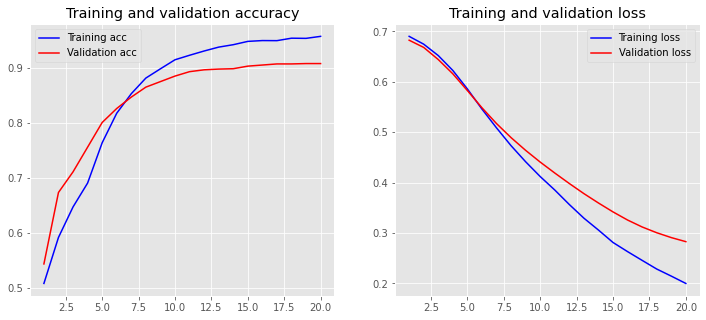

In [ ]:
# Creating model with the optimal paramteres 
# with param: {'dropout': 0.2, 'embedding_dim': 50, 'maxlen': 100, 'units': 10 , 'vocab_size': 10000 }
model = create_model( units = 10, vocab_size = 10000, maxlen = 100, embedding_dim= 50, vectorize_layer = vectorize_layer)
model.summary()

# Train the neural net and evaluate results 
history = model.fit(train_data, epochs = 20, batch_size = 10, verbose = 1, validation_data = test_data)
plot_history(history)